In [1]:
# import modules, styles and dependencies
%matplotlib inline
%matplotlib notebook
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import style
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import timedelta, date

# Reflect Tables into SQLAlchemy ORM

In [2]:
# python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# Create a connection to a SQLite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# view the classes from automap
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# pull 1 year worth of data from 2017-8-5
start_date = dt.datetime.strptime("2017-8-5", "%Y-%m-%d")
numdays = 365
date_list = [start_date - dt.timedelta(days = x)for x in range(0, numdays)]

# set up empty list to append dates as strings
str_dates = []

# set up loop to pull dates and add to list
for date in date_list:
    new_date = date.strftime("%Y-%m-%d")
    str_dates.append(new_date)

# pull precipitation (prcp) info
prcp_results = session.query(func.avg(Measurement.prcp), Measurement.date)\
                .filter(Measurement.date.in_(str_dates))\
                .group_by(Measurement.date)

# set up empty list to append precipiation info
prcp_data = []
for res in prcp_results:
    prcp_data.append(res[0])
    
# set up the query results as a Pandas DataFrame
prcp_df = pd.DataFrame([str_dates[::-1], prcp_data[::-1]]).T
prcp_df.rename(columns = {0: "Date", 1: "Precipitation"}, inplace = True)
prcp_df.set_index("Date", inplace = True)
prcp_df.head()

,Precipitation
Date,
2016-08-06,0.03
2016-08-07,0.015
2016-08-08,0.0175
2016-08-09,0.075
2016-08-10,0.0466667


<function matplotlib.pyplot.show(*args, **kw)>

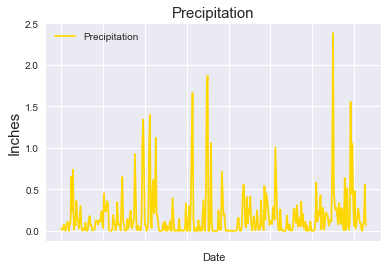

In [59]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(color="gold")
plt.title("Precipitation", fontsize=15)
plt.ylabel("Inches", fontsize=15)
plt.savefig("images/precipitation.png")
plt.show

In [10]:
prcp_df.head()

,Precipitation
Date,
2016-08-06,0.03
2016-08-07,0.015
2016-08-08,0.0175
2016-08-09,0.075
2016-08-10,0.0466667


In [11]:
# display summary stats for precipitation data
prcp_df["Precipitation"].describe()

count     365.0
unique    232.0
top         0.0
freq       46.0
Name: Precipitation, dtype: float64

In [12]:
# find the total active stations
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count

(9)

In [13]:
# list the most active stations in descending order
station_counts = session.query(Measurement.station, func.count(Measurement.prcp))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.prcp).desc())

# print stations
for station in station_counts:
    print(station)
    
# set a variable for station names
active_station = station_counts[0][0]

('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [14]:
# find the lowest temp, highest temp, and avg temp
tobs_results = session.query(Measurement.tobs)\
              .filter(Measurement.date.in_(str_dates))\
              .filter(Measurement.station == active_station)

tobs_data = []
for row in tobs_results:
    tobs_data.append(row[0])

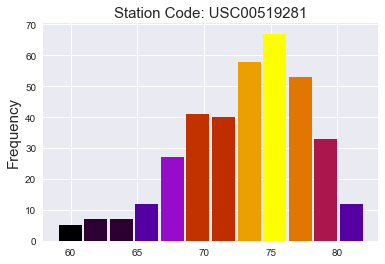

In [50]:
# set colomap to something fun
cm = plt.cm.get_cmap('gnuplot')

# set up histogram and settings
n, bins, patches = plt.hist(tobs_data, bins=12, color='green', rwidth=.9)

# set title
plt.title("Station Code: USC00519281", fontsize=15)

# set up y label
plt.ylabel("Frequency", fontsize=15)

# normalize color values
col = (n-n.min())/(n.max()-n.min())
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.savefig("images/bar_graph.png")
plt.show()

In [16]:
# find the min, avg, and max temps for date range
def calc_temps(start_date, end_date):
 # convert to datetime
    startDate = dt.datetime.strptime(start_date, "%Y-%m-%d")
    startDate = startDate.replace(startDate.year - 1)
    endDate = dt.datetime.strptime(end_date, "%Y-%m-%d")
    endDate = endDate.replace(endDate.year - 1)
    
# get date range
    delta = endDate - startDate
    date_range = []
    for i in range(delta.days + 1):
        date_range.append(startDate + timedelta(days=i))
        
    # convert to string
    str_date_range = []
    for date in date_range:
        new_date = date.strftime("%Y-%m-%d")
        str_date_range.append(new_date)
        
    # get stats    
    temp_avg = session.query(func.avg(Measurement.tobs))\
               .filter(Measurement.date.in_(str_date_range))[0][0]
    temp_min = session.query(func.min(Measurement.tobs))\
               .filter(Measurement.date.in_(str_date_range))[0][0]
    temp_max = session.query(func.max(Measurement.tobs))\
               .filter(Measurement.date.in_(str_date_range))[0][0]
        
    return temp_avg, temp_min, temp_max

In [17]:
# calculate the tmin, tavg, and tmax for date range
temp_analysis = calc_temps("2016-05-06", "2016-05-12")

# set up variables to store data
tavg = temp_analysis[0]
tmin = temp_analysis[1]
tmax = temp_analysis[2]

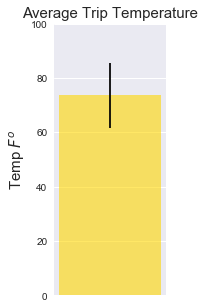

In [60]:
# set up average trip temperature graph
plt.figure(figsize=(2,5))
plt.bar(1,height=tavg, yerr=(tmax-tmin), width=0.0001, alpha=0.6, color="gold")
plt.title("Average Trip Temperature",fontsize=15)
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp $F^o$", fontsize=15)
plt.savefig("images/Trip_Avg_Temp.png") 
plt.show()